
#Intro (About dataset)

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The classes are drawn from the urban sound taxonomy. For a detailed description of the dataset and how it was compiled please refer to our paper. All excerpts are taken from field recordings uploaded to www.freesound.org. The files are pre-sorted into ten folds (folders named fold1-fold10) to help in the reproduction of and comparison with the automatic classification results reported in the article above.

In addition to the sound excerpts, a CSV file containing metadata about each excerpt is also provided. <br>

#Methodology<br>
There are 3 basic methods to extract features from audio file :<br> a) Using the mffcs data of the audio files (we can then use RNN based models like LSTMs, GRUs to train on these features)<br>
b) Using a spectogram image of the audio and then converting the same to data points (As is done for images). This is easily done using mel_spectogram function of Librosa (This involves CNNs)<br>
c) Combining both features to build a better model. (Requires a lot of time to read and extract data).

I have chosen to use the second method.
The labels have been converted to categorical data for classification.
CNN has been used as the primary layer to classify data

In [1]:
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz

--2020-11-26 16:59:22--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘UrbanSound8K.tar.gz’

UrbanSound8K.tar.gz 100%[===================>]   5.61G  32.6MB/s    in 3m 5s   

2020-11-26 17:02:27 (31.1 MB/s) - ‘UrbanSound8K.tar.gz’ saved [6023741708/6023741708]



In [2]:
import shutil
shutil.unpack_archive("/content/UrbanSound8K.tar.gz", "/content/UrbanSound8K")

In [3]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras

# Libraries for Classification and building Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

pd.plotting.register_matplotlib_converters()
%matplotlib inline
import seaborn as sns

# Project Specific Libraries
import skimage
import glob
import librosa
import librosa.display
import numpy as np
from matplotlib.pyplot import specgram

In [22]:
# Forming a panda dataframe from the metadata file and analysing it
df = pd.read_csv("/content/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv")

In [23]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing




    slice_file_name: The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where: [fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken [classID] = a numeric identifier of the sound class (see description of classID below for further details) [occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording [sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

    fsID: The Freesound ID of the recording from which this excerpt (slice) is taken

    start The start time of the slice in the original Freesound recording

    end: The end time of slice in the original Freesound recording

    salience: A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

    fold: The fold number (1-10) to which this file has been allocated.

    classID: A numeric identifier of the sound class: 0 = air_conditioner 1 = car_horn 2 = children_playing 3 = dog_bark 4 = drilling 5 = engine_idling 6 = gun_shot 7 = jackhammer 8 = siren 9 = street_music

    class: The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music.


In [24]:
# Count of datapoints in each of the folders
df["fold"].value_counts()

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

In [25]:
dat1, sampling_rate1 = librosa.load('/content/UrbanSound8K/UrbanSound8K/audio/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('/content/UrbanSound8K/UrbanSound8K/audio/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

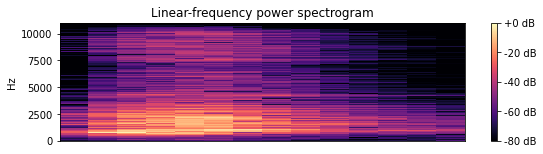

In [26]:
# Using Librosa to analyse random sound sample - SPECTOGRAM
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

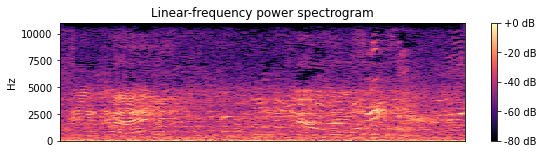

In [27]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

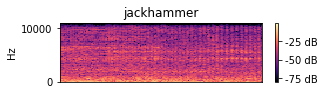

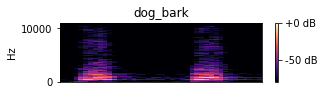

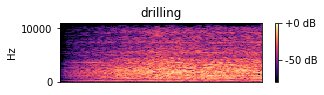

In [28]:
''' Using random samples to observe difference in waveforms '''

arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(192, 197, 2):
    path = '/content/UrbanSound8K/UrbanSound8K/audio/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])


Feature Extraction and Database Building
Method

    I have used Librosa to extract features.
    To do so, I will go through each fold and extract the data for each file. Then I have used the mel_spectogram function of librosa to extract the spectogram data as a numpy array.
    After reshaping and cleaning the data, 75-25 split has been performed.
    Classes (Y) have been converted to Categorically Encoded Data usng Keras.utils

Note : Running the parser function may take upto 45 minutes depending on your system since it has to extract spectogram data for 8732 audio files


In [29]:
'''EXAMPLE'''
dat1, sampling_rate1 = librosa.load('/content/UrbanSound8K/UrbanSound8K/audio/fold5/100032-3-0-0.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 14)

In [35]:
feature = []
label = []

def parser(row):
    # Function to load files and extract features
    for i in tqdm(range(8732)):
        file_name = '/content/UrbanSound8K/UrbanSound8K/audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

In [36]:
temp = parser(data)

100%|██████████| 8732/8732 [26:26<00:00,  5.50it/s]


In [37]:
import pickle
with open('temp.pickle', 'wb') as f:
  pickle.dump(temp, f)

In [40]:
with open('temp.pickle', 'rb') as f:
  clf = pickle.load(f)
type(clf)

list

In [41]:
temp = np.array(temp)
data = temp.transpose()

In [42]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([8732, 128])

(8732,) (8732,)


In [43]:
for i in range(8732):
  X[i] = (X_[i])

In [44]:
Y = to_categorical(Y)

In [45]:
print(X.shape)
print(Y.shape)

(8732, 128)
(8732, 10)


In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [47]:
X_train = X_train.reshape(6549, 16, 8, 1)
X_test = X_test.reshape(2183, 16, 8, 1)

In [48]:
input_dim = (16, 8, 1)

#Creating Keras Model and Testing
Model 1:

    CNN 2D with 64 units and tanh activation.
    MaxPool2D with 2*2 window.
    CNN 2D with 128 units and tanh activation.
    MaxPool2D with 2*2 window.
    Dropout Layer with 0.2 drop probability.
    DL with 1024 units and tanh activation.
    DL 10 units with softmax activation.
    Adam optimizer with categorical_crossentropy loss function.

90 epochs have been used.


In [57]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

In [58]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [59]:
history = model.fit(X_train, Y_train, epochs = 90, batch_size = 50, validation_data = (X_test, Y_test))

Epoch 1/90
131/131 [==============================] - 1s 4ms/step - loss: 1.5601 - accuracy: 0.4654 - val_loss: 1.3561 - val_accuracy: 0.5492
Epoch 2/90
131/131 [==============================] - 0s 3ms/step - loss: 1.1341 - accuracy: 0.6195 - val_loss: 1.0991 - val_accuracy: 0.6349
Epoch 3/90
131/131 [==============================] - 0s 3ms/step - loss: 0.9476 - accuracy: 0.6804 - val_loss: 1.0143 - val_accuracy: 0.6720
Epoch 4/90
131/131 [==============================] - 0s 3ms/step - loss: 0.8578 - accuracy: 0.7155 - val_loss: 1.0264 - val_accuracy: 0.6853
Epoch 5/90
131/131 [==============================] - 0s 3ms/step - loss: 0.7804 - accuracy: 0.7407 - val_loss: 0.8791 - val_accuracy: 0.7229
Epoch 6/90
131/131 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.7791 - val_loss: 0.8440 - val_accuracy: 0.7270
Epoch 7/90
131/131 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.7965 - val_loss: 0.8420 - val_accuracy: 0.7508
Epoch 

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 8, 64)         640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 2, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)             

In [61]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

69/69 [==============================] - 0s 2ms/step - loss: 0.9572 - accuracy: 0.8598
[0.9571614265441895, 0.8598259091377258]


In [62]:
preds = np.argmax(predictions, axis = 1)

In [63]:
result = pd.DataFrame(preds)
result.to_csv("submission.csv")

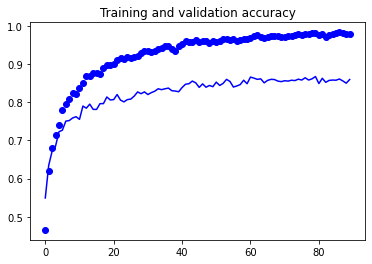

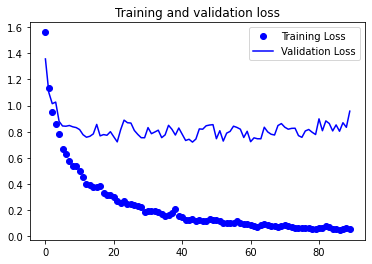

In [65]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

